In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices()
print("Devices:", physical_devices)

2023-09-19 16:18:31.318961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 16:18:32.822606: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 16:18:32.828077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 16:18:42.496904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-19 16:19:06.434983: I itex/core/wrapper/itex_gpu_wrapper.cc:35] Intel Extension for Tensorflow* GPU backend is loaded.
2023-09-19 16:19:06.710694: W itex/core/ops/op_init.cc:58] Op: _QuantizedMaxPool3D is already registered in Tensorflow
2023-09-19 16:19:06.741558: E itex/cor

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint
from tensorflow import keras
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

/home/u203489/.conda/envs/bird/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Constants
INPUT = "MelSpec"

# Train test split constants
TEST_SIZE = 0.3
RANDOM_STATE = 42
SHUFFLE = True

# Modeling constants
checkpoint_filepath = "checkpoints/vit-base-patch16-224-in21k"
val_split = 0.1
learning_rate = 0.001
dropout_rate=0.1
weight_decay = 0.0001
batch_size = 256
num_epochs = 200
image_size = 1152  
patch_size = 96 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 16
hl_head_units = [2048, 1024] 
num_classes = 40
input_shape = (512, 512, 3)

# Prepare data for modeling

In [4]:
# map a label to each bird species 
d = {}
counter = 0
for root, dirs, files in os.walk(INPUT, topdown=False):
    for dir in dirs:
        d[dir] = counter
        counter = counter + 1
d

{'African Paradise Flycatcher': 0,
 'Dark-capped Bulbul': 1,
 'Chorister Robin-Chat': 2,
 'Rattling Cisticola': 3,
 'Cape Bunting': 4,
 'Fork-tailed Drongo': 5,
 'Cape Robin-Chat': 6,
 'Orange-breasted Bushshrike': 7,
 'Cape White-eye': 8,
 'Rufous-naped Lark': 9,
 'Sabota Lark': 10,
 'White-browed Scrub Robin': 11,
 'Eastern Clapper Lark': 12,
 'Karoo Prinia': 13,
 'Sombre Greenbul': 14,
 'Green Wood Hoopoe': 15,
 'Bar-throated Apalis': 16,
 'Fiery-necked Nightjar': 17,
 'Black-headed Oriole': 18,
 'Cape Batis': 19,
 'Ring-necked Dove': 20,
 'African Reed Warbler': 21,
 'Southern Boubou': 22,
 'Black-backed Puffback': 23,
 'African Pipit': 24,
 'Olive Bushshrike': 25,
 'Tawny-flanked Prinia': 26,
 'Southern Double-collared Sunbird': 27,
 'Long-billed Crombec': 28,
 'African Rock Pipit': 29,
 'Bokmakierie': 30,
 'White-bellied Sunbird': 31,
 'Green-backed Camaroptera': 32,
 'Crested Barbet': 33,
 'Karoo Scrub Robin': 34,
 'Black Cuckoo': 35,
 'Red-chested Cuckoo': 36,
 'White-browed Ro

In [5]:
# generate the feature (X) and target (y) arrays
X = []
y = []
for root, dirs, files in os.walk(INPUT, topdown=False):
    for dir in dirs:
        files = os.listdir(INPUT + rf'/{dir}')
        for name in files:
            img = Image.open(os.path.join(INPUT + rf'/{dir}', name))
            X.append(np.asarray(img.convert("RGB")))
            y.append(d[dir])
X = np.asarray(X)
y = np.asarray(y)

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1856, 512, 512, 3)
y shape:  (1856,)


In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=SHUFFLE)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}") 

X_train shape: (1299, 512, 512, 3), X_test shape: (557, 512, 512, 3), y_train shape: (1299,), y_test shape: (557,)


# Modeling

In [7]:
# Patches of a melspec
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 1152 X 1152
Patch size: 96 X 96
Patches per image: 144
Elements per patch: 27648


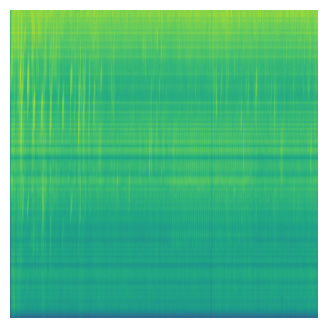

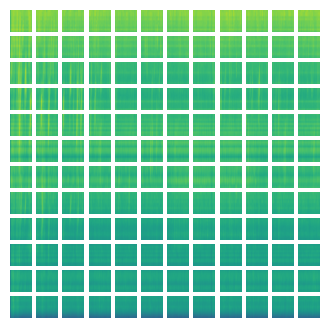

In [8]:
# Plot patches of a random melspec sample
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
# Encode patches
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def create_model():
    # Input layer
    input_layer = keras.layers.Input(shape=input_shape)
    # Data augmentation layer
    data_augmentation = keras.Sequential(
        [
            keras.layers.Normalization(),
            keras.layers.Resizing(image_size, image_size),
            keras.layers.RandomFlip("horizontal"),
            keras.layers.RandomRotation(factor=0.02),
            keras.layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    data_augmentation.layers[0].adapt(X_train)
    augmented = data_augmentation(input_layer)
    # patches layer 
    patches = Patches(patch_size)(augmented)
    # Encoded patches layer
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create Transformer layer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)
        # Join previous layer and attention layer
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # Hidden layer 1
        for units in transformer_units:
            x3 = keras.layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = keras.layers.Dropout(dropout_rate)(x3)
        # Join previous layers and 1st hidden layer
        encoded_patches = keras.layers.Add()([x3, x2])

    # Layer normalization 3
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Layer flattening
    representation = keras.layers.Flatten()(representation)
    # Regularisation
    representation = keras.layers.Dropout(dropout_rate)(representation)
    
    # Hidden layer 2
    for units in hl_head_units:
        representation = keras.layers.Dense(units, activation=tf.nn.gelu)(representation)
        features = keras.layers.Dropout(0.5)(representation)
        
    # Output layer
    output_layer = keras.layers.Dense(num_classes)(features)
    
    # Initialize model
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    # Optimizer
    optimizer = tf.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Save model checkpoints
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    return model, checkpoint_callback 

In [ ]:
# Train model
model, check_pt = create_model()
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split, callbacks=[check_pt])

Epoch 1/200
5/5 [==============================] - 143s 23s/step - loss: 7.6434 - accuracy: 0.0419 - top-5-accuracy: 0.1660 - val_loss: 7.2153 - val_accuracy: 0.0385 - val_top-5-accuracy: 0.2077
Epoch 2/200
5/5 [==============================] - 115s 23s/step - loss: 7.5848 - accuracy: 0.0505 - top-5-accuracy: 0.1848 - val_loss: 4.1022 - val_accuracy: 0.0538 - val_top-5-accuracy: 0.2000
Epoch 3/200
5/5 [==============================] - 115s 23s/step - loss: 4.2377 - accuracy: 0.0701 - top-5-accuracy: 0.2181 - val_loss: 3.7253 - val_accuracy: 0.0846 - val_top-5-accuracy: 0.2308
Epoch 4/200
5/5 [==============================] - 111s 22s/step - loss: 3.7611 - accuracy: 0.0556 - top-5-accuracy: 0.2515 - val_loss: 3.5587 - val_accuracy: 0.0538 - val_top-5-accuracy: 0.2231
Epoch 5/200
5/5 [==============================] - 111s 22s/step - loss: 3.5808 - accuracy: 0.0838 - top-5-accuracy: 0.2891 - val_loss: 3.5560 - val_accuracy: 0.0692 - val_top-5-accuracy: 0.2692
Epoch 6/200
5/5 [========

In [ ]:
# Evaluate model
_, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}")
print(f"\nTest top 5 accuracy: {round(top_5_accuracy * 100, 2)}")